In [18]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
from cosmikyu import nn as cnn
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random
from minkfncts2d import MF2D
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")

norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
compts = ["kappa", "ksz", "tsz", "ir", "rad"]

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

In [20]:
overwrite=False
STAT_TEST = stats.STATS("sehgal_cosmoganwgpv_minko_281220", output_dir=stat_dir, overwrite=overwrite)
shape = (128,128)
SDS_test = datasets.SehgalDataSet(sehgal_dir, "test281220_fromcat", transforms=[SDN],
                                  dummy_label=False, dtype=np.float64, shape=(5,)+shape)
nsample = 50#len(SDS_test)

z = np.linspace(-15,15,300)
for i, compt in enumerate(compts):
    for j in range(nsample):
        if j % 100 == 0: print(compt, j)
        st_idx_temp = "%s_{}"%compt
        if STAT_TEST.has_data(st_idx_temp.format("chi"), j):
            continue
        storage = np.zeros((len(z),3))
        for k, threshold in enumerate(z):
            f, u, chi = MF2D((SDS_test[j][i]).astype(np.float), threshold)
            storage[k,:] = np.array([f, u, chi])
        STAT_TEST.add_data(st_idx_temp.format("f"), j, storage[:,0].copy())
        STAT_TEST.add_data(st_idx_temp.format("u"), j, storage[:,1].copy())    
        STAT_TEST.add_data(st_idx_temp.format("chi"), j, storage[:,2].copy())
            
STAT_TEST.add_data("z", 0, z)
ret = STAT_TEST.get_stats()     

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_sehgal_cosmoganwgpv_minko_281220.npz
kappa 0
ksz 0
tsz 0
ir 0
rad 0
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_sehgal_cosmoganwgpv_minko_281220.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_sehgal_cosmoganwgpv_minko_281220.npz
calculating stats


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/d

In [21]:
STanh = cnn.ScaledTanh(15., 2./15.)
LF = cnn.LinearFeature(5,5)
SC = transforms.SehgalSubcomponets([0])


norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
#experiment_id = "ec72a32f599f4ccda54a556ba56abea4"#"e2d04f98e77a49c5804db3379217986f"
#model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/{}/model".format(experiment_id)
experiment_id = "6c187e10f7ad45c8b6e6ebb7c0b15d31"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_281220/{}/model".format(experiment_id)
print(model_dir)

overwrite =False
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
SDN_GK = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=["kappa"])
SDS_input = datasets.SehgalDataSet(sehgal_dir, "train_tertiary281220_fromcat", 
                                   transforms=[SDN], dummy_label=False, dtype=np.float32)

STAT_GEN = stats.STATS(experiment_id+"_minko", output_dir=stat_dir, overwrite=overwrite)
#save_points = [20,29,30]
save_points = [3,13]
shape = (128,128)
nsample = 100
cuda = False

z = np.linspace(-15,15,300)
for save_point in save_points: 
    FORSE = gan.VAEGAN_WGP("sehgal_forse_081020", (5,)+shape, nconv_fcgen=64,
                          nconv_fcdis=64, cuda=cuda, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, kernal_size=4, stride=2,
                          padding=1, output_padding=0, gen_act=[LF,STanh], nin_channel=5, 
                          nout_channel=5, nthresh_layer_gen=0, nthresh_layer_disc=0, dropout_rate=0)

    FORSE.load_states(model_dir, "_{}".format(save_point))
    
    for i, compt in enumerate(compts):
        for j in range(nsample):
            if j % 6000 == 0: print(compt, j)
            st_idx_temp = "%s_{}_%d"%(compt, save_point)
            
            #if STAT_GEN.has_data(st_idx_temp.format("chi"), j):
                #continue
            sample = FORSE.generate_samples(SDS_input[j], concat=False, train=False).data.numpy()[0].astype(np.float64)

            storage = np.zeros((len(z), 3))
            for k, threshold in enumerate(z):
                f, u, chi = MF2D(sample[i], threshold)
                storage[k,:] = np.array([f, u, chi])
            
            STAT_GEN.add_data(st_idx_temp.format("f"), j, storage[:,0].copy())
            STAT_GEN.add_data(st_idx_temp.format("u"), j, storage[:,1].copy())    
            STAT_GEN.add_data(st_idx_temp.format("chi"), j, storage[:,2].copy())

    STAT_GEN.add_data("z", 0, z)
ret = STAT_GEN.get_stats()  

Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_281220/6c187e10f7ad45c8b6e6ebb7c0b15d31/model
[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6c187e10f7ad45c8b6e6ebb7c0b15d31_minko.npz
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _3
kappa 0
ksz 0
tsz 0
ir 0
rad 0


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _13
kappa 0
ksz 0
tsz 0
ir 0
rad 0
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6c187e10f7ad45c8b6e6ebb7c0b15d31_minko.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6c187e10f7ad45c8b6e6ebb7c0b15d31_minko.npz
calculating stats


In [22]:
def key2label(key):
    storage = {"kappa":r"$  \kappa  $",
               "ksz":" kSZ ",
               "tsz":" tSZ ",
               "ir":" CIB ",
               "rad":"Radio",
              }
    return storage[key]

<>:15: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<ipython-input-23-b299e6e737ce>:15: DeprecationWarning: invalid escape sequence \c
  "chi":("Minkowski functional $\chi$ (Euler characteristic)", "Arbitrary Unit")


Squared number of pixels


<Figure size 432x288 with 0 Axes>

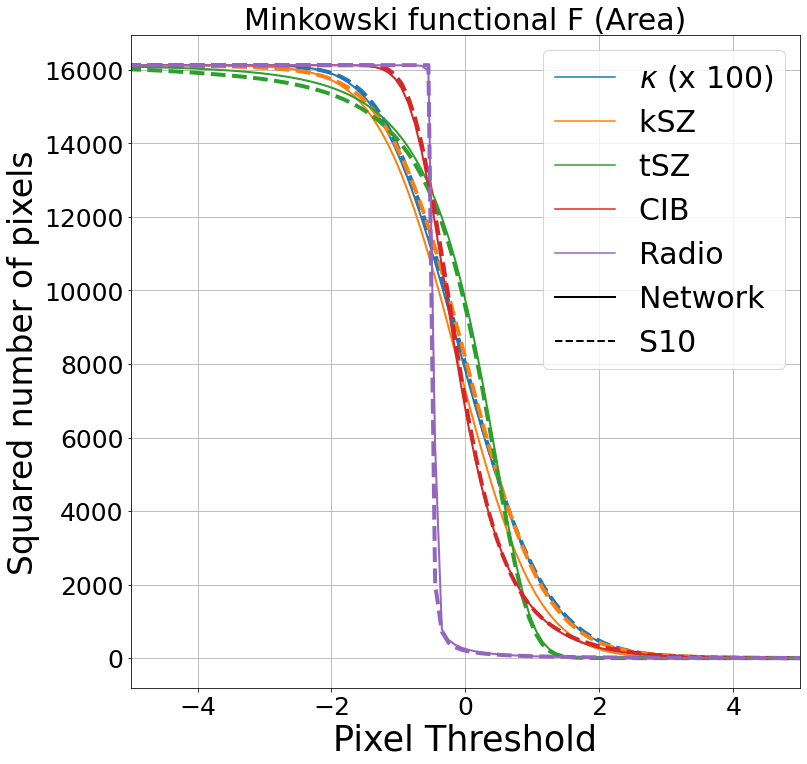

Number of pixels


<Figure size 432x288 with 0 Axes>

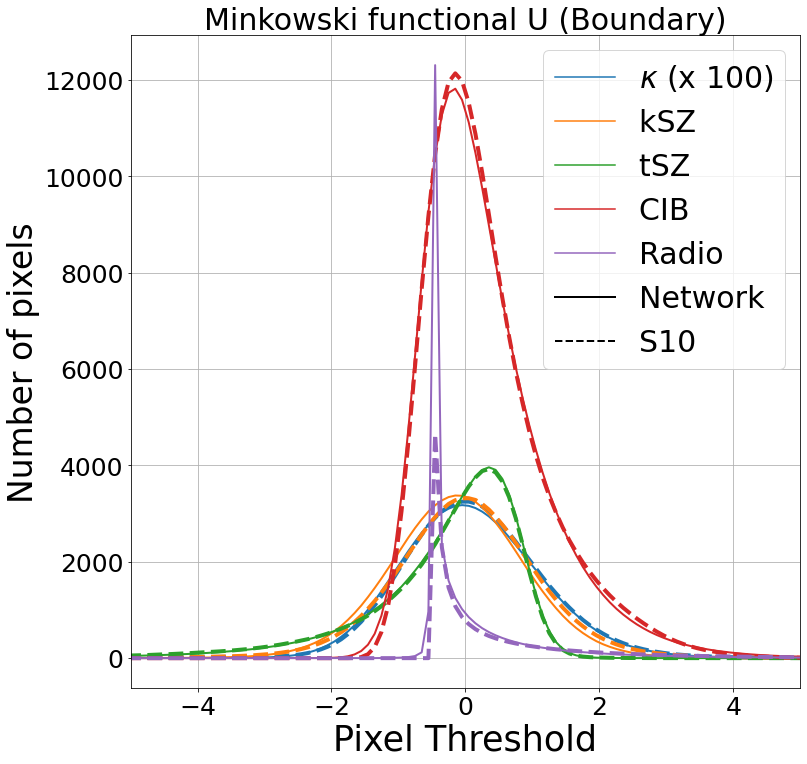

Arbitrary Unit


<Figure size 432x288 with 0 Axes>

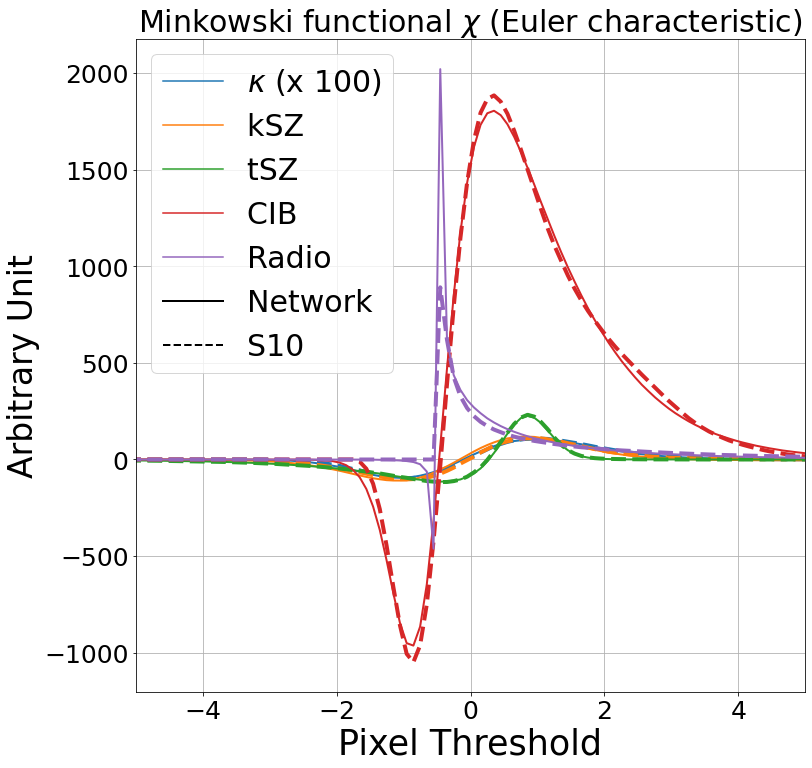

In [23]:
## ps

def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]

def mink2label(key):
    storage = {"f":("Minkowski functional F (Area)", "Squared number of pixels"),
               "u":("Minkowski functional U (Boundary)", "Number of pixels"),
               "chi":("Minkowski functional $\chi$ (Euler characteristic)", "Arbitrary Unit")
              }
    return storage[key]

flux_cut = False

for mink_idx in ["f", "u", "chi"]:
    plt.clf()
    title, ylabel = mink2label(mink_idx)
    print(ylabel)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    
   
    for i, compt in enumerate(compts):
        color = next(ax._get_lines.prop_cycler)['color']
        st_idx_temp = "%s_{}"%compt
        key = st_idx_temp.format(mink_idx)
        plt.plot(z, STAT_TEST.stats[key]["mean"], alpha=1, lw=4, marker="",markersize=8, color=color, ls="--")
        st_idx_temp = "%s_{}_%d"%(compt, save_points[-1])
        key = st_idx_temp.format(mink_idx)
        plt.plot(z, STAT_GEN.stats[key]["mean"], alpha=1, lw=2, marker="",markersize=12, color=color, ls="-")
        plt.plot([],[], label=key2label(compt), color=color)

    plt.title(title, fontsize=30)
    plt.plot([],[], lw=2, marker="", ls="-", label="Network", color="k")    
    plt.plot([],[], lw=2, marker="", label="S10", color="k", ls="--")
    ax.set_ylabel(ylabel, fontsize=33)
    ax.set_xlabel("Pixel Threshold", fontsize=35)
    plt.legend(fontsize=30, ncol=1)

    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    plt.xlim(-5,5)
    ax.grid()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(plot_path(f"141020_minko_{mink_idx}.pdf"), bbox_inches='tight')
    plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:9: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<ipython-input-7-066f549885a3>:9: DeprecationWarning: invalid escape sequence \c
  label="$\chi$ (Euler characteristic)", color="g")


<Figure size 432x288 with 0 Axes>

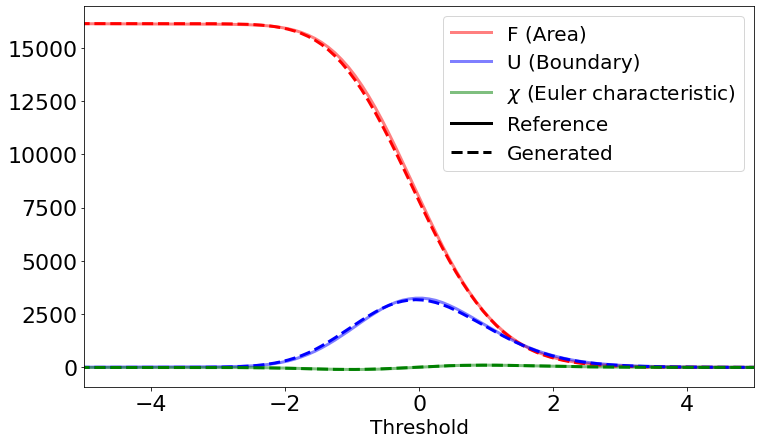

<Figure size 432x288 with 0 Axes>

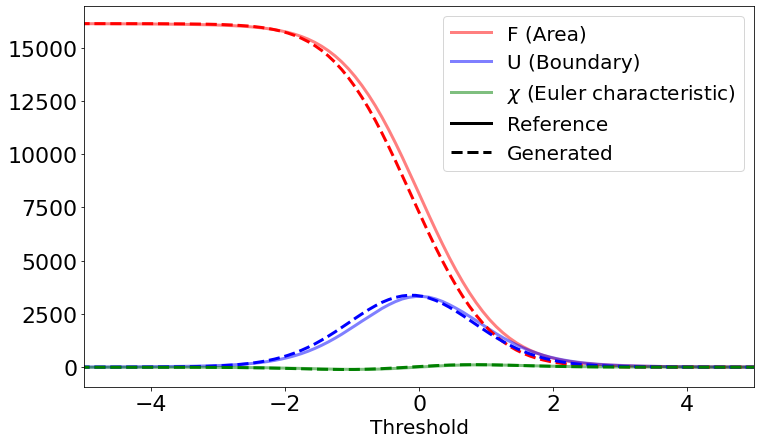

<Figure size 432x288 with 0 Axes>

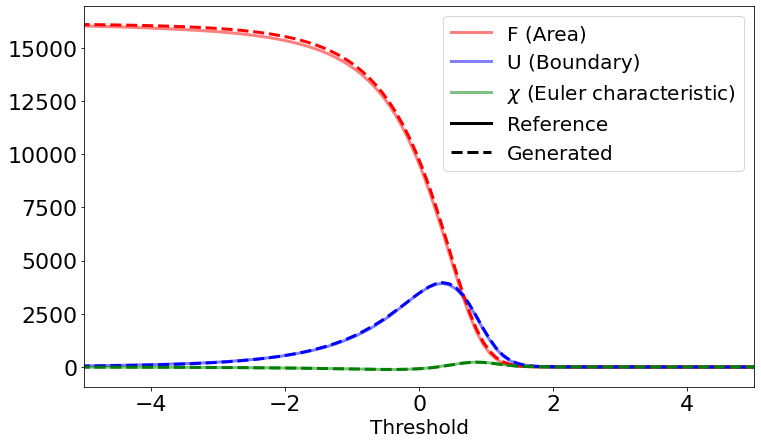

<Figure size 432x288 with 0 Axes>

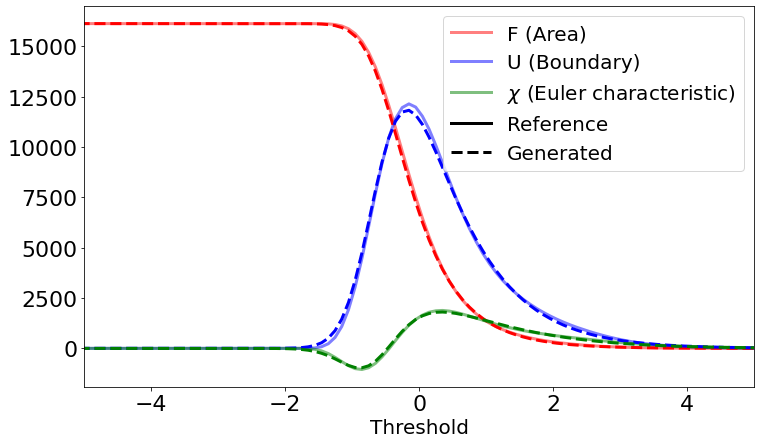

<Figure size 432x288 with 0 Axes>

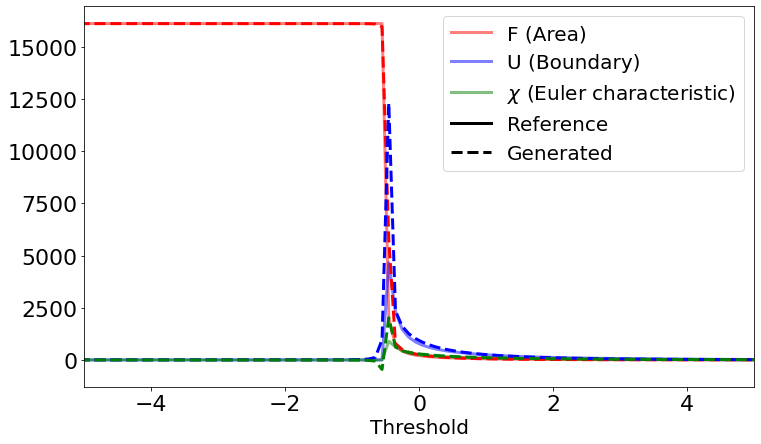

In [7]:

for i, compt in enumerate(compts):
    plt.clf()
    st_idx_temp = "%s_{}"%compt
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], alpha=0.5, lw=3, label="F (Area)", color="r")
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], alpha=0.5,lw=3, label="U (Boundary)", color="b")
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], alpha=0.5,lw=3,
             label="$\chi$ (Euler characteristic)", color="g")
    
    st_idx_temp = "%s_{}_%d"%(compt, save_points[-1])
    mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="r")
    mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="b")
    mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="g")
    plt.plot([],[], lw=3, color="k", label="Reference")
    plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
    plt.xlim(-5,5)
    plt.yscale("linear")
    plt.legend(fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    plt.xlabel("Threshold", fontsize=20)
    plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \c
<>:37: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:37: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:37: DeprecationWarning: invalid escape sequence \c
<ipython-input-8-5c49a2e3ee56>:11: DeprecationWarning: invalid escape sequence \c
  label="$\chi$ (Euler characteristic)", color="g")
<ipython-input-8-5c49a2e3ee56>:37: DeprecationWarning: invalid escape sequence \c
  axes[2,1].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")


0 0 0
1 0 1
2 1 0
3 1 1
4 2 0


<Figure size 432x288 with 0 Axes>

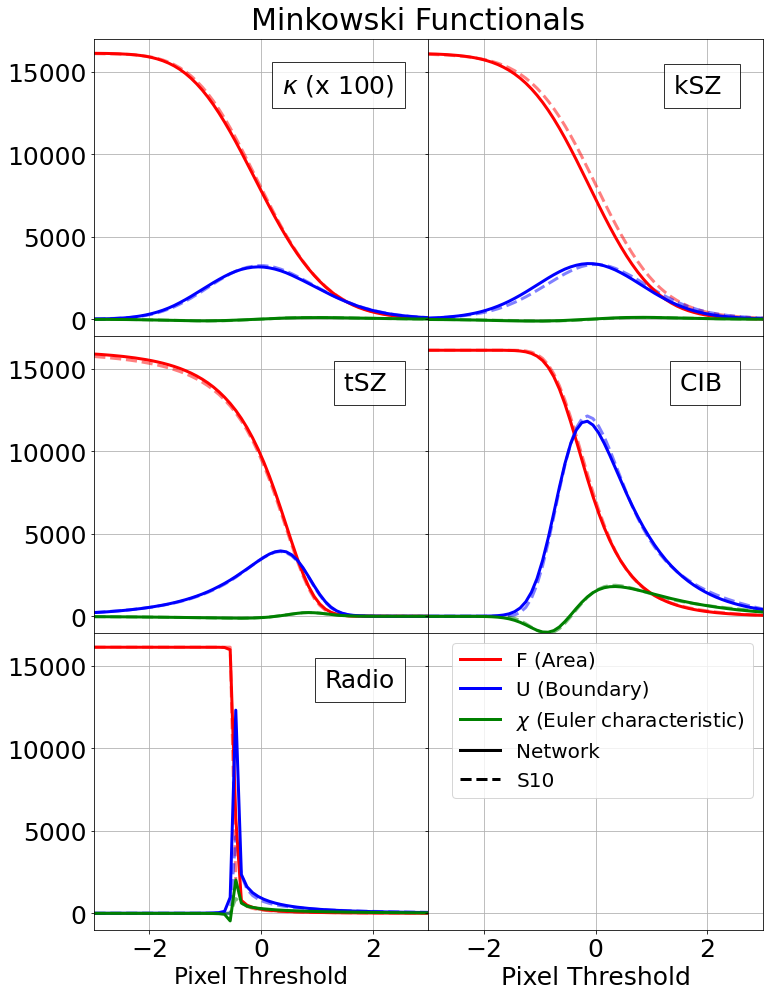

In [8]:
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(12,15), sharex='all', sharey='all')
for i, compt in enumerate(compts):
    yidx = i // 2
    xidx = i % 2
    print(i, yidx, xidx)
    st_idx_temp = "%s_{}"%compt
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], ls="--", alpha=0.5, lw=3, label="F (Area)", color="r")
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], ls="--", alpha=0.5, lw=3, label="U (Boundary)", color="b")
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], ls="--", alpha=0.5, lw=3,
             label="$\chi$ (Euler characteristic)", color="g")
    
    st_idx_temp = "%s_{}_%d"%(compt, save_points[-1])
    mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="-", lw=3, color="r")
    mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="-", lw=3, color="b")
    mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="-", lw=3, color="g")
    axes[yidx,xidx].set_xlim([-3,3])
    axes[yidx,xidx].set_ylim(-1000, 17000)
    axes[yidx,xidx].tick_params(axis='both', which='major', labelsize=25)
    axes[yidx,xidx].tick_params(axis='both', which='minor', labelsize=25)
    axes[yidx,xidx].grid()
    axes[yidx,xidx].text(0.90, 0.8, key2label(compt),
        verticalalignment='bottom', horizontalalignment='right',
        transform=axes[yidx,xidx].transAxes,
        color='k', fontsize=25, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.subplots_adjust(wspace=None, hspace=None)
    axes[yidx,xidx].set_xlabel("Pixel Threshold", fontsize=23)
    #plt.plot([],[], lw=3, color="k", label="Reference")
    #plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
plt.suptitle("Minkowski Functionals", fontsize=30)
fig.subplots_adjust(top=0.95)
axes[2,1].plot([],[], lw=3, color="r", label="F (Area)")
axes[2,1].plot([],[], lw=3, color="b", label="U (Boundary)")
axes[2,1].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")
axes[2,1].plot([],[], ls="-", lw=3, color="k", label="Network")
axes[2,1].plot([],[], ls="--", lw=3, color="k", label="S10")
axes[2,1].tick_params(axis='both', which='major', labelsize=25)
axes[2,1].tick_params(axis='both', which='minor', labelsize=25)
axes[2,1].grid()
axes[2,1].set_xlabel("Pixel Threshold", fontsize=25)
axes[2,1].legend(fontsize=20)
#axes[0,0].get_yaxis().set_visible(False)
#axes[1,0].get_yaxis().set_visible(False)
#axes[2,0].get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(plot_path("141020_minko.pdf"))
plt.show()

In [9]:
def mink2label(key):
    storage = {"f":("F (Area)"),
               "u":("Minkowski functional U (Boundary)", "Number of pixels"),
               "chi":("Minkowski functional $\chi$ (Euler characteristic)", "Arbitrary Unit")
              }
    return storage[key]
def key2label(key):
    storage = {"kappa":r"$  \kappa$",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \c
<>:4: DeprecationWarning: invalid escape sequence \c
<>:4: DeprecationWarning: invalid escape sequence \c
<ipython-input-9-885ba7a9bd8a>:4: DeprecationWarning: invalid escape sequence \c
  "chi":("Minkowski functional $\chi$ (Euler characteristic)", "Arbitrary Unit")


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 0 0
1 0 1
2 1 0
3 1 1


<Figure size 432x288 with 0 Axes>

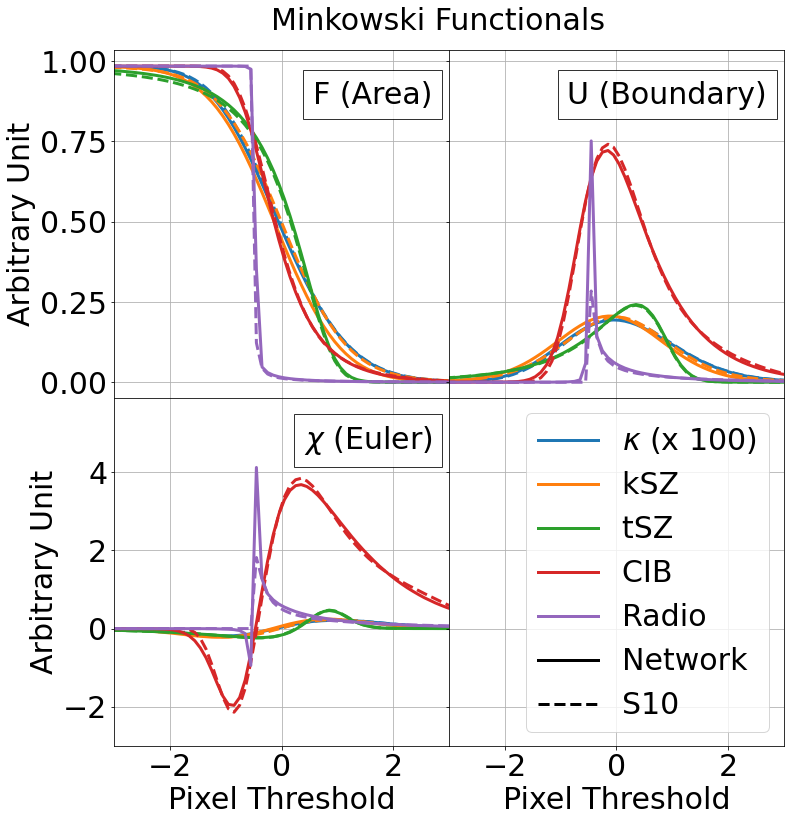

In [24]:
import matplotlib.ticker as mtick
f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.clf()
fig, axes = plt.subplots(2,2, figsize=(12,12), sharex='all', sharey='row')
npix = sample[0].size
for i in np.arange(4):
    yidx = i // 2
    xidx = i % 2
    print(i, yidx, xidx)
    mult_fact = 1/ npix if i < 2 else 1/490
    if i < 3:
        mink_idx = ["f", "u", "chi"][i]
        for j, compt in enumerate(compts):
            color = next(axes[yidx, xidx]._get_lines.prop_cycler)['color']
            st_idx_temp = "%s_{}"%compt
            key = st_idx_temp.format(mink_idx)
            
            axes[yidx, xidx].plot(z, STAT_TEST.stats[key]["mean"]*mult_fact, alpha=1, lw=3, marker="",markersize=8, color=color, ls="--")
            st_idx_temp = "%s_{}_%d"%(compt, save_points[-1])
            key = st_idx_temp.format(mink_idx)
            axes[yidx, xidx].plot(z, STAT_GEN.stats[key]["mean"]*mult_fact, alpha=1, lw=3, marker="",markersize=12, color=color, ls="-")
            #plt.plot([],[], label=key2label(compt), color=color)


    
    #st_idx_temp = "%s_{}"%compt
    
    
    
    #axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], ls="--", alpha=0.5, lw=3, label="F (Area)", color="r")
    #axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], ls="--", alpha=0.5, lw=3, label="U (Boundary)", color="b")
    #axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], ls="--", alpha=0.5, lw=3,
    #         label="$\chi$ (Euler characteristic)", color="g")
    
    #st_idx_temp = "%s_{}_%d"%(compt, save_points[-1])
    #mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    #axes[yidx,xidx].plot(z, mean, ls="-", lw=3, color="r")
    #mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    #axes[yidx,xidx].plot(z, mean, ls="-", lw=3, color="b")
    #mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    #axes[yidx,xidx].plot(z, mean, ls="-", lw=3, color="g")
    axes[yidx,xidx].set_xlim([-3,3])
    #axes[yidx,xidx].set_ylim(-1000, 17000)
    axes[yidx,xidx].tick_params(axis='both', which='major', labelsize=30)
    axes[yidx,xidx].tick_params(axis='both', which='minor', labelsize=30)
    axes[yidx,xidx].grid()
    #axes[yidx,xidx].text(0.90, 0.8, key2label(compt),
    #    verticalalignment='bottom', horizontalalignment='right',
    #    transform=axes[yidx,xidx].transAxes,
    #    color='k', fontsize=25, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    #axes[yidx,xidx].set_xlabel("Pixel Threshold", fontsize=23)
    #axes[yidx,xidx].yaxis.set_major_formatter(mtick.FuncFormatter(g))
    #plt.plot([],[], lw=3, color="k", label="Reference")
    #plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
plt.suptitle("Minkowski Functionals", fontsize=30)
fig.subplots_adjust(top=0.93)
for j, compt in enumerate(compts):
    color = next(axes[1, 1]._get_lines.prop_cycler)['color']
    plt.plot([],[], label=key2label(compt), color=color, lw=3)
#axes[0,0].plot([],[], lw=3, color="r", label="F (Area)")
#axes[0,1].plot([],[], lw=3, color="b", label="U (Boundary)")
#axes[1,0].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")
axes[1,1].plot([],[], ls="-", lw=3, color="k", label="Network")
axes[1,1].plot([],[], ls="--", lw=3, color="k", label="S10")
axes[1,0].set_ylim(-3,5.9)
axes[1,1].tick_params(axis='both', which='major', labelsize=30)
axes[1,1].tick_params(axis='both', which='minor', labelsize=30)
axes[0,0].text(0.95, 0.83, "F (Area)",
    verticalalignment='bottom', horizontalalignment='right',
    transform=axes[0,0].transAxes,
    color='k', fontsize=30, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
axes[0,1].text(0.95, 0.83, "U (Boundary)",
    verticalalignment='bottom', horizontalalignment='right',
    transform=axes[0,1].transAxes,
    color='k', fontsize=30, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
axes[1,0].text(0.95, 0.83, r"$\chi$ (Euler)",
    verticalalignment='bottom', horizontalalignment='right',
    transform=axes[1,0].transAxes,
    color='k', fontsize=30, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

axes[0,0].set_ylabel("Arbitrary Unit", fontsize=30)
axes[1,0].set_ylabel("Arbitrary Unit", fontsize=30)
axes[1,0].set_xlabel("Pixel Threshold", fontsize=30)
axes[1,1].set_xlabel("Pixel Threshold", fontsize=30)
#axes[1,1].plot([],[])
#axes[0,0].legend(fontsize=30)
#axes[1,0].legend(fontsize=30)
#axes[0,1].legend(fontsize=30)
axes[1,1].legend(fontsize=30)
plt.subplots_adjust(hspace=0, wspace=0)
#axes[1,1].grid()

#axes[0,0].get_yaxis().set_visible(False)
#axes[1,0].get_yaxis().set_visible(False)
#axes[2,0].get_yaxis().set_visible(False)

#axes[1,1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))



plt.savefig(plot_path("141020_minko_full.pdf"), bbox_inches='tight')
plt.show()